# Imports

In [1]:
import sys, os

import s3fs
import xarray as xr
import pandas as pd

import progressbar

import warnings

from math import sqrt
from joblib import Parallel, delayed

from scipy import integrate
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import imageio

sys.path.append('../utilities')
import GrIS_committedSLR_calibration_utilities as utils

import boto3

import pickle


import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

# Setup

In [2]:
start_year = 2007.
end_year = 2015.

grid_size = 5000.
grid_extent = np.array([-720500.0, 960500.0, -3450500.0, -569500.0])

x_centers = np.arange(grid_extent[0]+grid_size/2, grid_extent[1]-grid_size/2, grid_size)
y_centers = np.arange(grid_extent[2]+grid_size/2, grid_extent[3]-grid_size/2, grid_size)

#run_names = ['velocity_case_2', 'thickness_case_2', 'mass_sigmamodx20', 'velocity_case_4', 'thickness_case_3']
run_names = ['velocity_case_4', 'thickness_case_4', 'mass_sigmamodx20']


### Total VAF / GMSL

In [3]:
# Load total VAF / GMSL
vaf_cmmtt = dict()
vaf_ctrl = dict()
gmsl_anomaly_change_2100 = dict()

#vaf_files = [fn.replace('thickness','VAF',) for fn in cmmtt_files]
s3 = s3fs.S3FileSystem(anon=False)
vaf_files = s3.glob('dh-gapc/GrIS_committed_SLR/netcdfs/VAF/*cmmtt*VAF.nc')

ensembleIDs = list()
for iFile, vaf_file in enumerate(vaf_files):
    ensembleID = os.path.basename(vaf_file).split('.')[3]
    ensembleIDs.append(ensembleID)
    
    # Read cmmtt VAF netcdf
    with s3.open(vaf_file, 'rb') as f:
        vaf_ds = xr.open_dataset(f, engine='h5netcdf')

        limnsw = vaf_ds['limnsw'].data
        vaf_cmmtt[ensembleID] = limnsw
    
    
    # Read ctrl VAF netcdf
    vaf_file = vaf_file.replace('cmmtt','ctrl')
    
    with s3.open(vaf_file, 'rb') as f:
        vaf_ds = xr.open_dataset(f, engine='h5netcdf')

        limnsw = vaf_ds['limnsw'].data
        vaf_ctrl[ensembleID] = limnsw
    
    
    vaf_anomaly = vaf_cmmtt[ensembleID] - vaf_ctrl[ensembleID]
    vaf_anomaly_change_2100 = vaf_anomaly[-1] - vaf_anomaly[0]
    gmsl_anomaly_change_2100[ensembleID] = -(vaf_anomaly_change_2100/1e12)/361.8


### LHS variables

In [4]:
# Load the LHS variables

# Load the ensemble IDs
df = pd.read_csv('s3://dh-gapc/GrIS_committed_SLR/LatinHypercubeSampling/IDs.txt', sep=' ', header=None)

# Select just the ensembleIDs with data
rows = list()
for iFile, vaf_file in enumerate(vaf_files):
    ensembleID = os.path.basename(vaf_file).split('.')[3]
    rows.append(df.index[df[0] == ensembleID].to_list()[0])
rows = np.array(rows)

# Load the LHS variables
df = pd.read_csv('s3://dh-gapc/GrIS_committed_SLR/LatinHypercubeSampling/ensemble-128-4p-noID.tab', sep=' ')
cols = df.columns

lhs_vars = dict()
for icol, col in enumerate(cols):
    lhs_vars[col] = df.to_numpy()[rows,icol]

    
# LHS v1: friction
# read in LHS scalar and convert to the multiplication factor
# so that 0.5 is the default simulation (from the inversion)
# basal friction
# [0 1] --> [-50% +50%]
# [0 1] --> [0.5 1.5]
# 
# lhsv1 = 0.5 + lhs.fric(i)*1.0;
#
# Perturb basal friction coefficient
# pert_fric = md.friction.coefficient*lhsv1;

lhs_vars['V1'] = -50. + lhs_vars['V1']*100.

# LHS v2: viscosity
# read in LHS scalar
# [0 1] --> [-10K 10K]
#
# lhsv2 = -10 + lhs.visc(i)*20;
#
# Perturb temperature by adding anomaly (in degrees K)
# pert_temp = md.initialization.temperature+lhsv2;
#
# Ensure that temperature not higher than melting point
# pert_temp(pert_temp > md.materials.meltingpoint) = md.materials.meltingpoint;
# Perturb rheology_B (rigidity)
# pert_visc = cuffey(pert_temp);

lhs_vars['V2'] = -10. + lhs_vars['V2']*20.

# LHS v3: shift in mean smb
#       up to ~+/- 127.5 Gt averaged over entire ice sheet (in m/yr ice)
#       This is +30%/-30% of 1960-89 mean (or approximately 1 sigma)
# 
# Read in LHS scalar and convert to +/-0.3
# [0 1] --> [-30% +30%] (1 sigma of 1960-89 period)
# [0 1] --> [-0.3 0.3]
# lhsv3 = -0.3 + lhs.smb1(i)*0.6;

lhs_vars['V3'] = -30. + lhs_vars['V3']*60.;

# LHS v4: varying strength of seasonal cycle
#       from mean seasonal cycle of the 1960-1989 period
#       mean cycle = 1
#       varies between 0 (no cycle) and 2 (double amplitude)
# 
# lhsv4 = lhs.smb2(i)*2;

lhs_vars['V4'] = lhs_vars['V4']*200.;


### Dynamic dh from SERAC

In [5]:
# Read dynamic dh from SERAC
dh_dyn_obs = utils.read_SERAC_obs('SERAC/SERACAnnualRates2021JanIGSPres.csv')

# select obs
dh_dyn_obs_selected = utils.select_dh_obs(dh_dyn_obs, startYear=start_year, endYear=end_year) #, dhThresholdMax=-1)
print('selected number of obs: {:8d}'.format(len(dh_dyn_obs_selected)))


total    number of obs:    53224
selected number of obs:    16185


# Bayesian calibration

In [12]:
# Select the weights
s_j_list = list()
w_j_list = list()
for run_name in run_names:
    print(run_name)
    p = pickle.load(open('results/' + run_name + '/weights.p', 'rb'))
    s_j = p['s_j']
    s_j_list.append(s_j)
    w_j = p['w_j']
    w_j_list.append(w_j)
    
    with open('results/' + run_name + '/description.txt', 'r') as f: description = f.read()
    print(description)
    print('')
    
colors = list()
colors.append(plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
colors.append(plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
colors.append(plt.rcParams['axes.prop_cycle'].by_key()['color'][3])
#colors.append('k')

if len(run_names) > 3:
    import matplotlib
    from matplotlib import cm
    norm = matplotlib.colors.Normalize(vmin=0, vmax=10)
    
    for i in range(3,len(run_names)):
        colors.append(matplotlib.colors.to_hex(cm.tab10(norm(i))))


velocity_case_4
start_year = 2007; end_year = 2015; grid_size =     5000; residual_sigma_multiplier =  2000;

thickness_case_4
start_year = 2007; end_year = 2015; grid_size =     5000; dh_mod_obs_sigma_multiplier =  1500; dhThresholdMax = nan

mass_sigmamodx20
start_year = 2007; end_year = 2015; grid_size = N/A; residual_sigma_multiplier = 20;



In [7]:
# Combine scores
w_j_s = np.empty( (len(w_j_list),len(w_j_list[0])) )

for i in range(len(run_names)):
    #print(run_names[i])
    w_j_s[i,:] = np.array(w_j_list[i]**2)

w_j_ss = np.sum(w_j_s, axis=0)
w_j_rss = np.sqrt(w_j_ss)

# Renormalize
w_j_combined = w_j_rss / np.sum(w_j_rss)


## Plot posterior GMSL pdfs

prior     : 12.0%    5.0
velocity  : 15.6%    5.9
thickness : 11.9%    4.5
mass      : 31.9%    6.3
combined  : 21.2%    6.0


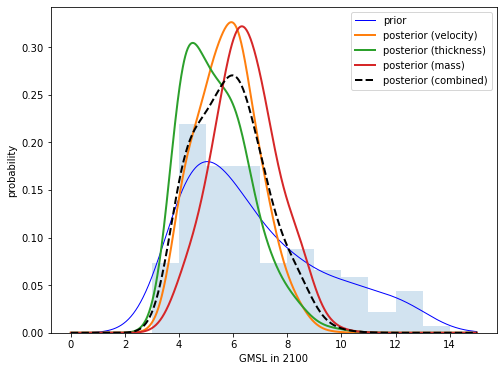

In [14]:
# Select thesholds
gmsl_thresholds = [7] # mm of GMSL rise in 2100


gmsl_anomaly_change_2100_values = list(gmsl_anomaly_change_2100.values())

bins = np.arange(0,16,1)

fig, ax = plt.subplots(figsize=(8,6))

# estimated density: prior
_ = ax.hist(gmsl_anomaly_change_2100_values, density=True, alpha=0.2, bins=bins)
x_kpde, gmsl_prior, gmsl_posterior = utils.gmsl_prior_posterior(gmsl_anomaly_change_2100_values, w_j_list[0])
ax.plot(x_kpde, gmsl_prior, label='prior', color='b', linewidth=1.)

for gmsl_threshold in gmsl_thresholds:
    idx_threshold = np.where(x_kpde > gmsl_threshold)[0][0]
    idx_map = np.argmax(gmsl_prior)
    cdf = integrate.cumtrapz(gmsl_prior[idx_threshold:], x_kpde[idx_threshold:], initial=0)
    print('{:10s}: {:4.1f}% {:6.1f}'.format('prior', 100 * gmsl_prior[idx_threshold], x_kpde[idx_map]))

#ax.set_xlim(0,.1)

for i, (run_name, w_j) in enumerate(zip(run_names, w_j_list)):
    run_name_short = run_name.split('_')[0]
    
    # Velocity weights
    x_kpde, gmsl_prior, gmsl_posterior = utils.gmsl_prior_posterior(gmsl_anomaly_change_2100_values, w_j)

    # estimated density: posterior (velocity)
    ax.plot(x_kpde, gmsl_posterior, colors[i], label='posterior (' + run_name_short + ')', linewidth=2.)

    for gmsl_threshold in gmsl_thresholds:
        idx_threshold = np.where(x_kpde > gmsl_threshold)[0][0]
        idx_map = np.argmax(gmsl_posterior)
        #cdf = integrate.cumtrapz(gmsl_posterior[idx_threshold:], x_kpde[idx_threshold:], initial=0)
        cdf = integrate.cumtrapz(gmsl_posterior[idx_threshold:], x_kpde[idx_threshold:], initial=0)
        print('{:10s}: {:4.1f}% {:6.1f}'.format(run_name_short, 100 * cdf[-1], x_kpde[idx_map]))
        
        idx = np.argmax(gmsl_posterior)

        
# Combined weights
x_kpde, gmsl_prior, gmsl_posterior = utils.gmsl_prior_posterior(gmsl_anomaly_change_2100_values, w_j_combined)

for gmsl_threshold in gmsl_thresholds:
    idx_threshold = np.where(x_kpde > gmsl_threshold)[0][0]
    idx_map = np.argmax(gmsl_posterior)
    #cdf = integrate.cumtrapz(gmsl_posterior[idx_threshold:], x_kpde[idx_threshold:], initial=0)
    cdf = integrate.cumtrapz(gmsl_posterior[idx_threshold:], x_kpde[idx_threshold:], initial=0)
    print('combined  : {:4.1f}% {:6.1f}'.format(100 * cdf[-1], x_kpde[idx_map]))

    idx = np.argmax(gmsl_posterior)

    
# estimated density: posterior (combined)
ax.plot(x_kpde, gmsl_posterior, 'k--', linewidth=2., label='posterior (combined)')

plt.legend()
plt.xlabel('GMSL in 2100')
plt.ylabel('probability')

plt.savefig('plots/gmsl_posteriors_all_plus_combined.pdf', bbox_inches='tight')


In [9]:
# Select the weights
run_name = 'velocity_case_1' #'case_1_vel'
c = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]

run_name = 'mass_sigmamodx20' #'case_1_vel'
c = 'k'


if run_name == '':
    w_j = None
else:
    p = pickle.load(open('results/' + run_name + '/weights.p', 'rb'))
    w_j = p['w_j']


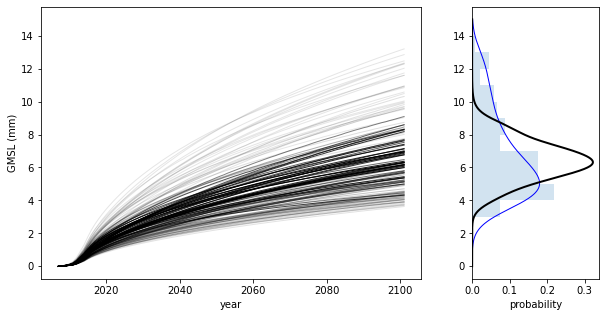

In [10]:
h_lines = list()

fig = plt.figure(figsize=(10,5))
#fig.suptitle('suptitle')

gs = GridSpec(1, 2, width_ratios=[3, 1]) #, height_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)

if w_j is None:
    c = 'b'
for iFile, vaf_file in enumerate(vaf_files):
    ensembleID = os.path.basename(vaf_file).split('.')[3]
    h = ax1.plot( range(2007, 2102), -(vaf_cmmtt[ensembleID] - vaf_ctrl[ensembleID])/1e12/361.8, c, linewidth=1. )
    h_lines.append(h[0])

if w_j is not None:
    for i, w_j_i in enumerate(w_j):
        alpha = np.interp(w_j_i, [np.min(w_j), np.max(w_j)], [0.1, 1.0])
        h_lines[i].set_alpha(alpha)

bins = np.arange(0,16,1)
ax2.hist(gmsl_anomaly_change_2100_values, density=True, alpha=0.2, bins=bins, orientation='horizontal')
ax2.plot(gmsl_prior, x_kpde, label='prior', color='b', linewidth=1.)
if w_j is not None:
    h = ax2.plot(gmsl_posterior, x_kpde, c, label='posterior ' + run_name, linewidth=2.)
#ax2.plot(gmsl_posterior_GRACE, x_kpde, label='posterior (GRACE)', color='k', linewidth=2.)

ax1.set_xlabel('year')
ax1.set_ylabel('GMSL (mm)')

ax2.set_xlabel('probability')

#ax[0].set_xlim(0, 7)
#ax[0].set_ylim(0, 1.5)

if w_j is None:
    plt.savefig('plots/gmsl_timeseries_prior.pdf', bbox_inches='tight')
else:
    plt.savefig('plots/gmsl_timeseries_posterior_{:s}.pdf'.format(run_name), bbox_inches='tight')


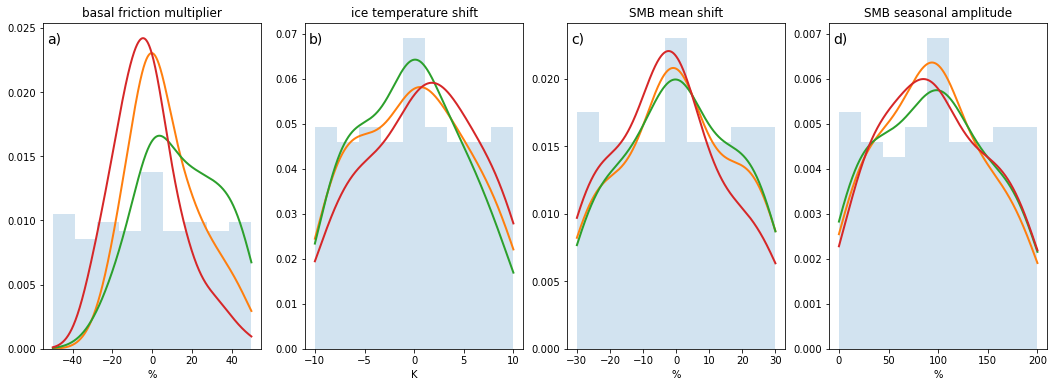

In [15]:
import importlib
importlib.reload(utils)

fig, ax = plt.subplots(1,4,figsize=(18,6))

for ivar, var in enumerate(lhs_vars.keys()):
    bins = np.linspace(np.min(lhs_vars[var]), np.max(lhs_vars[var]), 10)
    ax[ivar].hist(lhs_vars[var], density=True, alpha=0.2, bins=bins)
    x_kpde, lhs_var_prior, lhs_var_posterior = utils.gmsl_prior_posterior(lhs_vars[var], w_j_list[0], xmin=bins[0], xmax=bins[-1])
    #ax[ivar].plot(x_kpde, lhs_var_prior, label='prior', color='b', linewidth=1.)
    
for i, w_j in enumerate(w_j_list):
    for ivar, var in enumerate(lhs_vars.keys()):
        bins = np.linspace(np.min(lhs_vars[var]), np.max(lhs_vars[var]), 10)
        x_kpde, lhs_var_prior, lhs_var_posterior = utils.gmsl_prior_posterior(lhs_vars[var], w_j, xmin=bins[0], xmax=bins[-1])
        ax[ivar].plot(x_kpde, lhs_var_posterior, label=run_names[i], color=colors[i], linewidth=2.)

#ax[0].text(0.1, 0.1, 'a)')
ax[0].set_xlabel('%')
ax[1].set_xlabel('K')
ax[2].set_xlabel('%')
ax[3].set_xlabel('%')
ax[0].set_title('basal friction multiplier')
ax[1].set_title('ice temperature shift')
ax[2].set_title('SMB mean shift')
ax[3].set_title('SMB seasonal amplitude')

from pylab import text
text(0.05, 0.95,'a)',fontsize=14,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[0].transAxes)
text(0.05, 0.95,'b)',fontsize=14,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[1].transAxes)
text(0.05, 0.95,'c)',fontsize=14,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[2].transAxes)
text(0.05, 0.95,'d)',fontsize=14,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[3].transAxes)


plt.savefig('plots/lhs_variables_pdfs.pdf', bbox_inches='tight')


# Plot residuals for highest-weighted ensemble member from each calibration

../utilities/GrIS_committedSLR_calibration_utilities.py:247: RuntimeWarning: Mean of empty slice
  z_mod_grid[row, col] = np.nanmean(z_mod[np.min(idx_row):np.max(idx_row), \


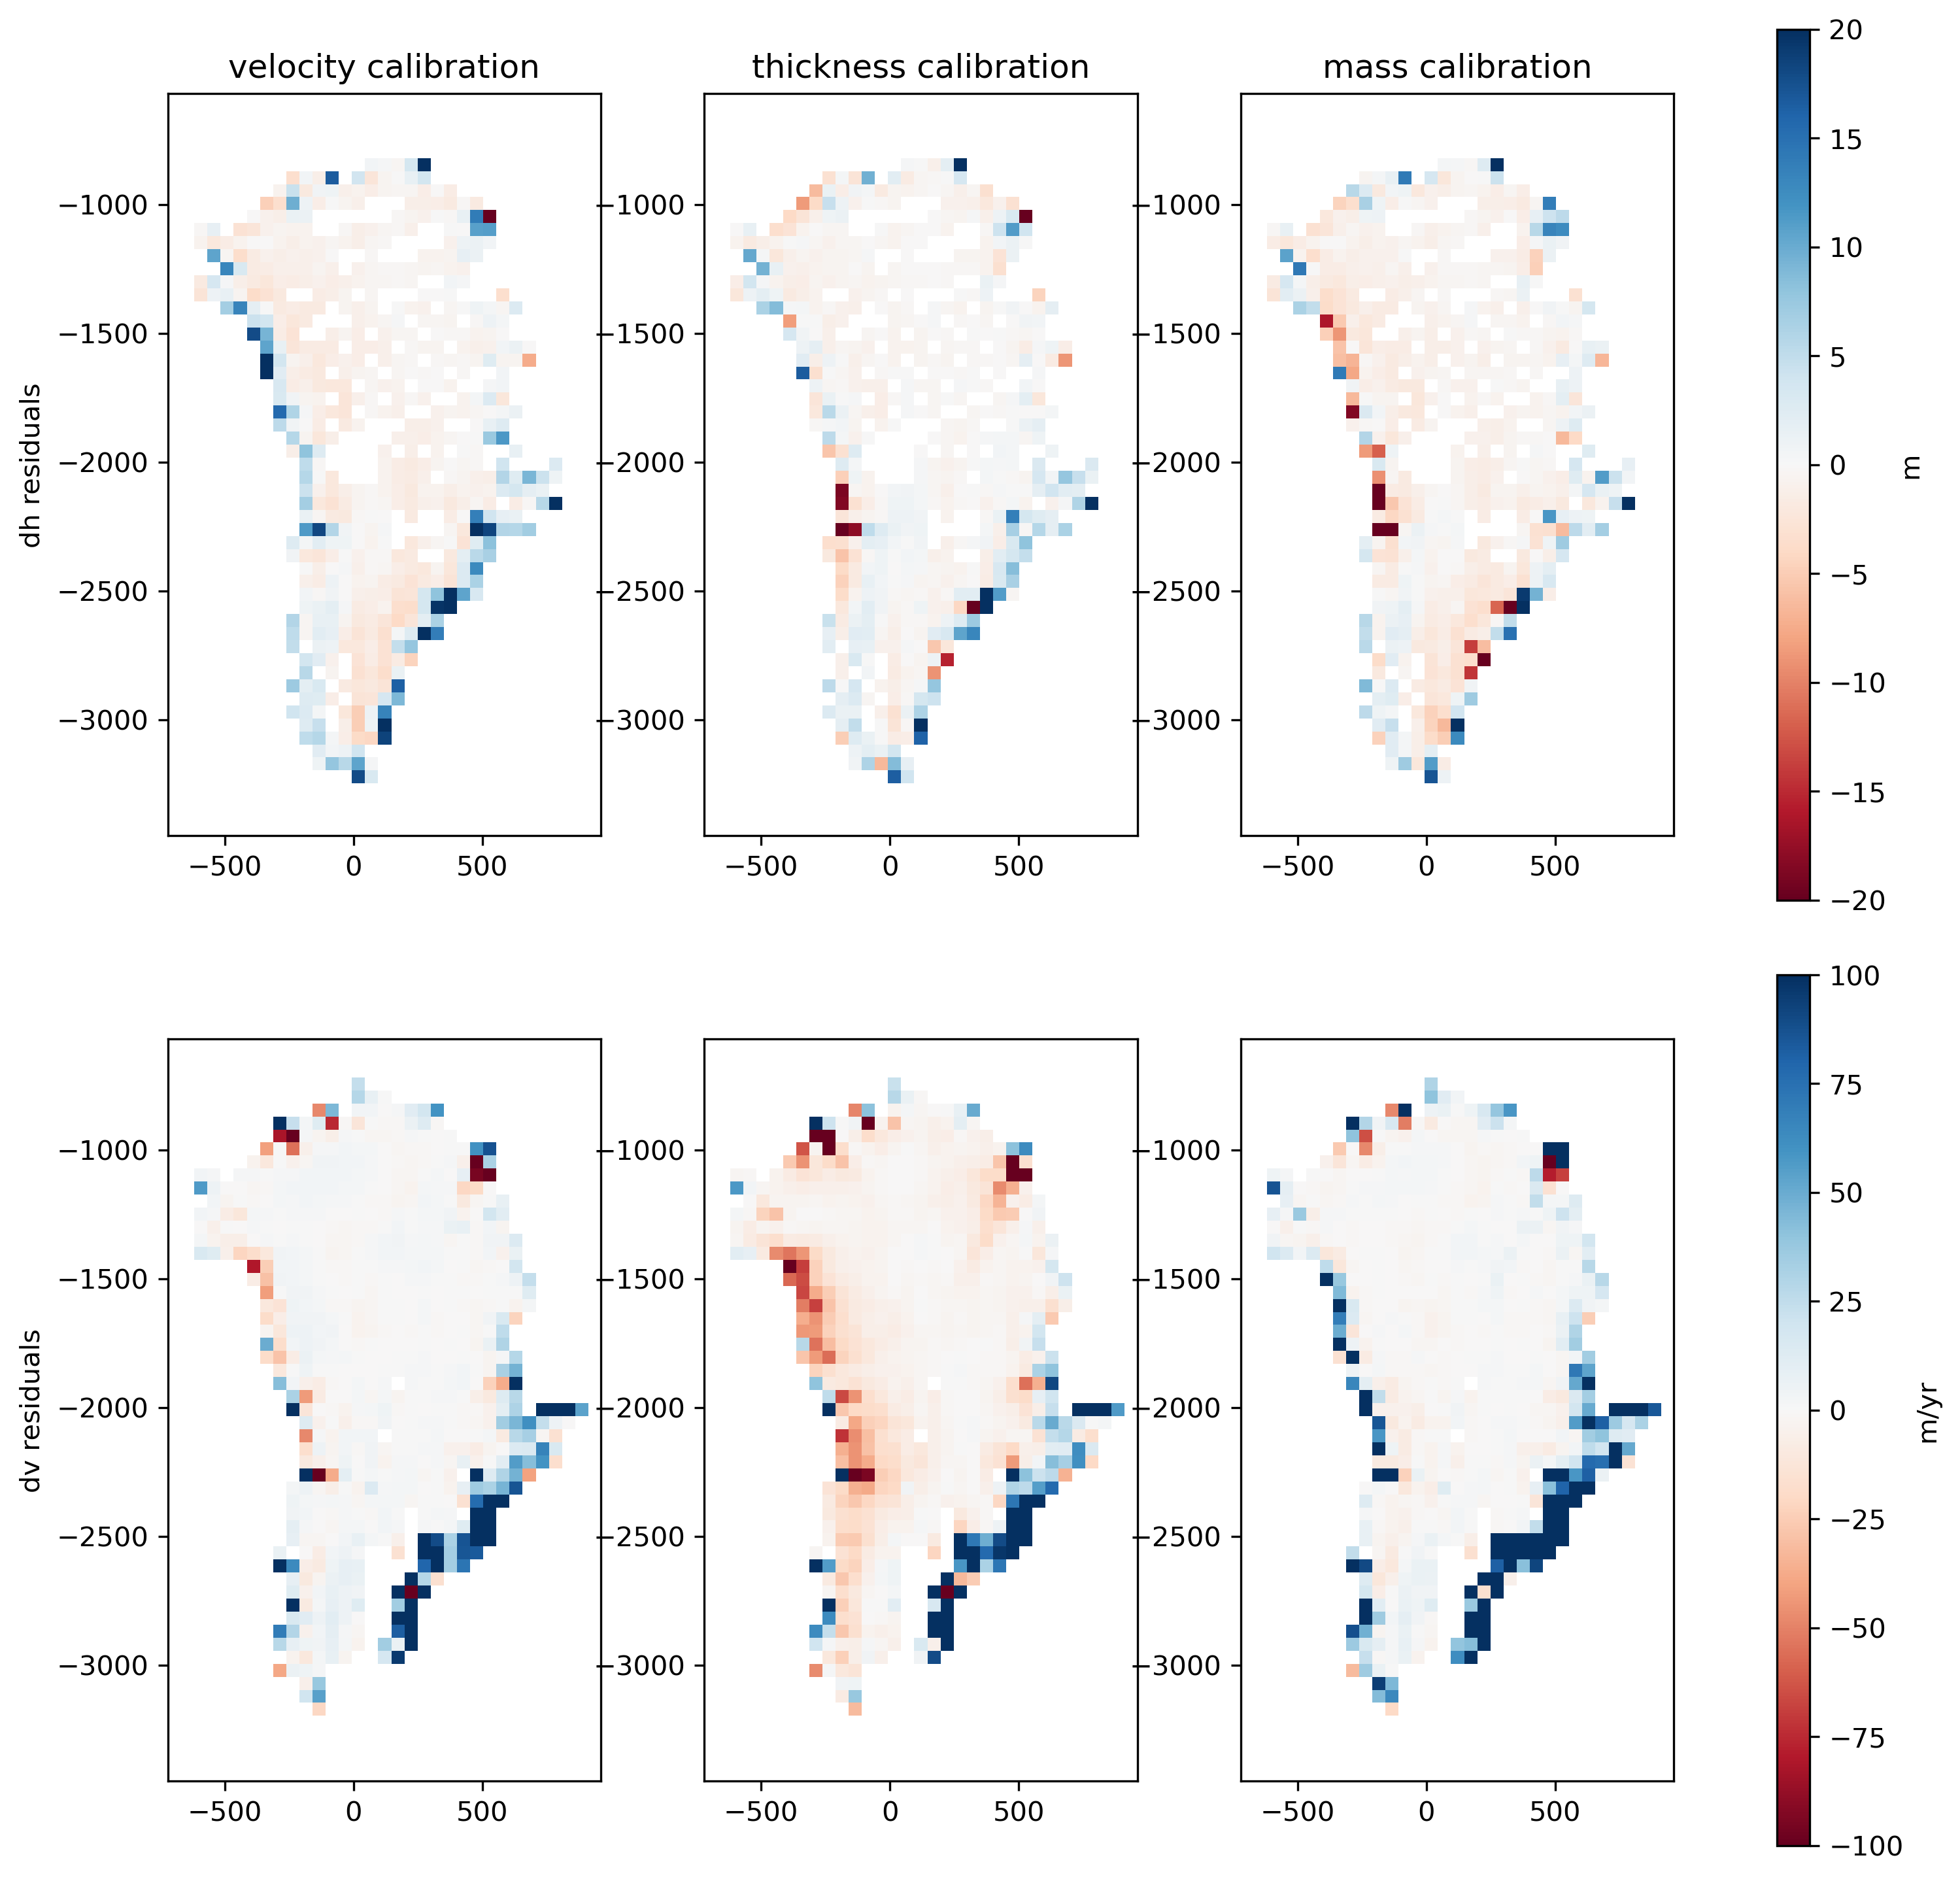

In [19]:
import importlib
importlib.reload(utils)


dhdynAnom_file_template = 'dh-gapc/GrIS_committed_SLR/zarr/dhdynAnom/gris.proj.2007-2015.????.dhdynAnom.nc.zarr'
dv_file_template = 'dh-gapc/GrIS_committed_SLR/zarr/velocity/gris.proj.2007-2015.????.dv.nc.zarr'

# Grid the observations
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    dh_obs_grid, dh_obs_sigma_grid = utils.grid_obs_dh(x_centers, y_centers, grid_size, grid_size, dh_dyn_obs_selected, \
                                                                                         startYear=start_year, endYear=end_year)

gridspec = {'width_ratios': [1, 1, 1, 0.075]}
fig, ax = plt.subplots(2,4,figsize=(10,10),dpi=300, gridspec_kw=gridspec)

# dh residuals
for i, w_j in enumerate(w_j_list):
    w_j_sorted_idx = sorted(range(len(w_j)), key=lambda i: w_j[i])
    ensembleID_highest_weight = ensembleIDs[w_j_sorted_idx[-1]]
    
    mod_name = dhdynAnom_file_template.replace('????', ensembleID_highest_weight)
    
    dh_mod_grid = utils.grid_mod_dh \
                                (mod_name, x_centers, y_centers, grid_size, grid_size) \

    residuals = dh_mod_grid - dh_obs_grid
    im = ax[0,i].imshow(residuals, extent=[e/1000. for e in grid_extent], \
                        cmap='RdBu', vmin=-20, vmax=20, origin='lower', \
                        aspect='equal')
    ax[0,i].set_title(run_names[i].split('_')[0] + ' calibration')

cax = ax[0,3]
cb = fig.colorbar(im, cax=cax, shrink=0.7)
cb.ax.set_ylabel('m')

ax[0,0].set_ylabel('dh residuals')


# dv residuals
for i, w_j in enumerate(w_j_list):
    # Plot the observations with the ensemble members with the highest and lowest weights
    w_j_sorted_idx = sorted(range(len(w_j)), key=lambda i: w_j[i])
    ensembleID_highest_weight = ensembleIDs[w_j_sorted_idx[-1]]

    mod_name = dv_file_template.replace('????', ensembleID_highest_weight)
    
    dv_mod_grid = utils.grid_mod_dh \
                                (mod_name, x_centers, y_centers, grid_size, grid_size, var_name='dv') \

    residuals = dv_mod_grid - dv_obs_grid
    im = ax[1,i].imshow(residuals, extent=[e/1000. for e in grid_extent], \
                        cmap='RdBu', vmin=-100, vmax=100, origin='lower', \
                        aspect='equal')

cax = ax[1,3]
cb = fig.colorbar(im, cax=cax, shrink=0.7)
cb.ax.set_ylabel('m/yr')

ax[1,0].set_ylabel('dv residuals')


# dM residuals


# Save figure
plt.tight_layout()
plt.savefig('plots/heighest_weight_ensemble_member_residuals.pdf', bbox_inches='tight')

